In [2]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi.oracle import Left
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'results'

In [162]:
args = Parameters({
    "dims": 2,
    "bias": True,
    "out_dir": "/home/pstefanou/Regression/Sanity",
    "samples": 1000,
    "c": 0,
    "batch_size": 1,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 1,
    "norm": False,
    "workers": 8,
    "steps": 500,
#     "step_lr": 100000000,
#     "step_lr_gamma": 1.0,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
    "phi": Left(Tensor([0]))
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.4473]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8862]], requires_grad=True)
alpha:  tensor([0.4270])


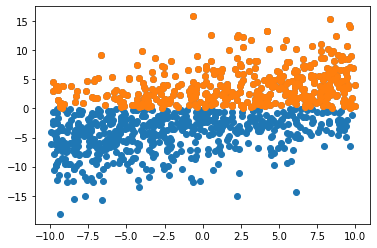

In [193]:
# distribution for generating feature vectors
k = 1
w = Uniform(-1, 1)
m = Uniform(-10, 10)
# m = MultivariateNormal(ch.zeros(k), ch.eye(k)/k)
phi = Left(Tensor([0.0]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(ch.ones(k, 1))
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, 1])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None


print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, k]))
    y = gt(X)

noise_var = Tensor([20.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [194]:
import math 

max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(9.9657)
beta:  tensor(9.9657)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

In [195]:
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc_norm, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc_norm)
trunc_ols.coef_, trunc_ols.intercept_

(array([[1.4934167]], dtype=float32), array([3.4829433], dtype=float32))

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([8.8344])
trunc reg noise var:  tensor([1.0000])


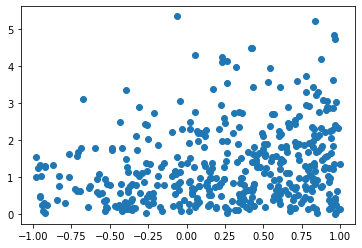

In [196]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

plt.scatter(x_trunc_norm, emp_stand_y_trunc)

Now, let's see what our new transformed regression looks like. 

In [197]:
new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt = LinearRegression(fit_intercept=True)
gt.fit(new_X, emp_stand_noised)
gt.coef_, gt.intercept_

(array([[1.3975106]], dtype=float32), array([-0.2689121], dtype=float32))

In [199]:
stand_noised = noised / ch.sqrt(noise_var)
stand_y_trunc = y_trunc / ch.sqrt(noise_var)

gt_ = LinearRegression(fit_intercept=True)
gt_.fit(new_X, stand_noised)
gt_.coef_, gt_.intercept_

(array([[0.9288156]], dtype=float32), array([-0.17872475], dtype=float32))

Truncated Regression with Known Empirical Variance

In [200]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=True, var=ch.ones(1))
res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
res.weight, res.bias

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

(Parameter containing:
 tensor([[0.9837]], requires_grad=True),
 Parameter containing:
 tensor([0.8331], requires_grad=True))

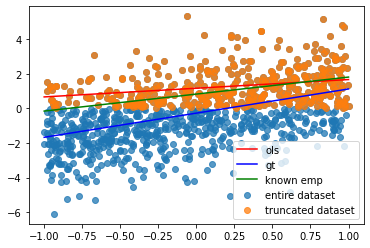

In [201]:
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
ols = LinearRegression(fit_intercept=True).fit(x_trunc_norm, emp_stand_y_trunc)
data = np.linspace(-1, 1, 100).reshape(100, 1)
plt.plot(data, ols.predict(data), color='r', label='ols')
plt.plot(data, gt.predict(data), color='blue', label='gt')
plt.plot(data, res(Tensor(data)).detach().numpy(), label='known emp', color='green')
plt.legend()

Truncated Regression with Known Variance

In [202]:
args.__setattr__('steps', 1500)

trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=True, var=ch.ones(1))
res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
res.weight, res.bias

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

(Parameter containing:
 tensor([[0.9631]], requires_grad=True),
 Parameter containing:
 tensor([-0.2441], requires_grad=True))

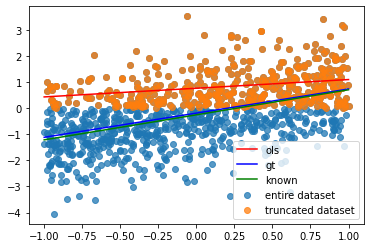

In [203]:
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
ols = LinearRegression().fit(x_trunc_norm, stand_y_trunc)
data = np.linspace(-1, 1, 100).reshape(100, 1)
plt.plot(data, ols.predict(data), color='r', label='ols')
plt.plot(data, gt_.predict(data), color='blue', label='gt')
plt.plot(data, res(Tensor(data)).detach().numpy(), label='known', color='green')
plt.legend()

Truncated Regression with Unknown Noise Variance

In [204]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=True)
res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
res.weight * res.lambda_.inverse(), res.bias * res.lambda_.inverse(), res.lambda_.inverse()

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

  0%|          | 0/427 [00:00<?, ?it/s]

(tensor([[0.9061]], grad_fn=<MulBackward0>),
 tensor([[-0.6417]], grad_fn=<MulBackward0>),
 tensor([[1.7159]], grad_fn=<InverseBackward>))

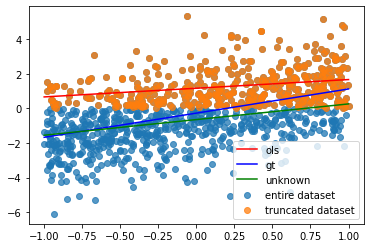

In [205]:
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
ols = LinearRegression(fit_intercept=True).fit(x_trunc_norm, emp_stand_y_trunc)
data = np.linspace(-1, 1, 100).reshape(100, 1)
plt.plot(data, ols.predict(data), color='r', label='ols')
plt.plot(data, gt.predict(data), color='blue', label='gt')
plt.plot(data, res(Tensor(data)).detach().numpy(), label='unknown', color='green')
plt.legend()

# Truncate at Zero and Run for High Variance

In [232]:
def generate_data(phi, d, w_lower, w_upper, x_lower, x_upper, noise_var, samples=10000, k=1): 
    """
    :param phi: truncation mechanism
    :param d: number of dimensions
    :param w_lower: lower bound for Uniform distribution for weight ground-truth
    :param w_upper: upper bound for Uniform distribution for weight ground-truth
    :param x_lower: lower bound for Uniform distribution for input features
    :param x_upper: upper bound for Uniform distribution for input features
    :param noise_var: (float) noise variance scale to noise regression
    :param samples: (int) number of samples to generate for gorund truth
    :param k: number of output logits
    :returns dictionary with X, y, x_trunc, y_trunc, and ground-truth layer
    """

    # distribution for generating feature vectors
    w = Uniform(w_lower, w_upper)
    dist = Uniform(x_lower, x_upper)
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d]))
        y = gt(X)
        
    # remove synthetic data from the computation graph
    with ch.no_grad():
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(Tensor([noise_var])) * ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
    return {'X': X, 'y': noised, 'x_trunc': x_trunc, 'y_trunc': y_trunc, 'gt': gt}

In [231]:
data = generate_data(phi, 10, -1, 1, -10, 10, 10)

In [ ]:
for i in range(args.trials):
    
    # distribution for generating feature vectors
    w = Uniform(w_lower, w_upper)
    dist = Uniform(x_lower, x_upper)
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d]))
        y = gt(X)

    for noise_var in range(1, 20): 
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(Tensor([noise_var])) * ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        
        # run empirical
        
        

In [73]:
res.lambda_.inverse()

tensor([[1.5632]], grad_fn=<InverseBackward>)

In [72]:
for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_mse': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_mse': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })
    # distribution for generating ground truth
    U = Uniform(args.lower, args.upper)
    U_ = Uniform(args.x_lower, args.x_upper)

    # generate ground truth
    gt = ch.nn.Linear(in_features=args.dims, out_features=1)
    gt.weight = ch.nn.Parameter(ch.ones(args.dims)[None,...])
    gt.bias = ch.nn.Parameter(ch.ones(1)[None,...]) if args.bias else None
    
    print("gt weight: ", gt.weight)
    print("gt bias: ", gt.bias)

    # create base classifier
    with ch.no_grad():
        # generate data
        X = U_.sample(ch.Size([args.samples, args.dims]))                # 
        y = gt(X)

    # increase variance up to 20
    for var in range(1, args.var_ + 1):
        noise_var = Tensor([2.0])[...,None]
        # remove synthetic data from the computation graph
        with ch.no_grad():
            # add noise to ground-truth pedictions
            noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
#             noised /= (y - noised).var(0)
            # truncate based off of the standardized data
            indices = args.phi(noised).nonzero(as_tuple=False).flatten()
            y_trunc, x_trunc = noised[indices], X[indices]
            alpha = Tensor([y_trunc.size(0) / args.samples])
            print("alpha: ", alpha)
            
        # l2 normalize inputs 
        beta = LA.norm(x_trunc, ord=float('inf'), dim=-1).max()*(args.dims**(.5))
        x_trunc = x_trunc / beta
        X_ = X / beta
        y_trunc_mu, y_trunc_sigma = y_trunc.mean(0), ch.sqrt(y_trunc.var(0))
        print("beta: ", beta)
            
        print("X norm: ", x_trunc.norm(dim=-1).max())
        
        # standardize ground-truth parameters
        X_, y_ 
        gt_ols = LinearRegression().fit(X_, (noised - y_trunc_mu / y_trunc_sigma))
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]])
        gt_var = (noised - gt_ols.predict(X_)).var(0)[None,...]
        print("gt params: ", gt_params)
        print("gt params norm: ", gt_params.norm())
        print("gt var: ", gt_var)

        # ols
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T / beta, Tensor(ols.intercept_)[..., None]])
        # check r2 for entire dataset
        ols_pred = ols.predict(X_)
        print("ols params: ", ols_params)
        print("ols var: ", ols_var)
        
        phi = Left(Tensor([(args.C - y_trunc_mu) / y_trunc_sigma]))
        args.__setattr__('phi', phi)
        
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(y.flatten(), ols_pred.flatten()), 
            'ols_param_mse': mse_loss(Tensor(ols_params), Tensor(gt_params)),
            'ols_var_mse': mse_loss(ols_var, noise_var), 
            })

        # truncated linear regression with known noise variance using empirical noise variance        
        trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias, var=ols_var)
        st = datetime.datetime.now()
        known_emp_results = trunc_reg.fit(x_trunc, y_trunc)
        known_emp_params = ch.cat([known_emp_results.weight.detach().cpu().T / beta, known_emp_results.bias.detach().cpu()[..., None]])
        # check r2 for entire dataset
        known_emp_pred = known_emp_results(X_).detach().cpu()
        print("known emp params: ", known_emp_params)


        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), known_emp_pred.flatten()), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': int((datetime.datetime.now() - st).total_seconds()), 
            })

        # truncated linear regression with known noise variance using actual noise variance
        trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias, var=ch.ones(1, 1))
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc, y_trunc)
        known_params = ch.cat([known_results.weight.detach().cpu().T / beta, known_results.bias.detach().cpu()[..., None]])
        known_time = int((datetime.datetime.now() - st).total_seconds())
        # check r2 for entire dataset
        known_pred = known_results(X_).detach().cpu()
        print("known params: ", known_params)

        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), known_pred.flatten()), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
            })

        # truncated linear regression with unknown noise variance
        args.__setattr__('batch_size', 100)
        trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias)
        st = datetime.datetime.now()
        unknown_results = trunc_reg.fit(x_trunc, y_trunc)
        var_ = unknown_results.lambda_.inverse().detach()
        unknown_params = ch.cat([(unknown_results.weight.detach() * var_).cpu().T / beta, (unknown_results.bias.detach() * var_).cpu()])
        # check r2 for entire dataset
        unknown_pred = unknown_results(X_).detach().cpu()
        print("unknown params: ", unknown_params)
        print("unknown var: ", var_)

        # unknown results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), unknown_pred.flatten()), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_mse': mse_loss(var_, gt_var),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
    
        # add additional metadata to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': float(var), 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
        
    # close current store
    store.close()

Logging in: /home/pstefanou/Regression/Sanity/a7690dae-e7a1-4448-9b26-5032fd3da8e8
gt weight:  Parameter containing:
tensor([[1., 1.]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[1.]], requires_grad=True)
alpha:  tensor([0.4501])
beta:  tensor(14.1421)
X norm:  tensor(0.9838)


NameError: name 'y_' is not defined

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)